## IMPORT LIBRARY

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

Pembacaan data baik file rating dan file movie 

In [3]:
rating = pd.read_csv('/content/sample_data/ratings.csv')

In [4]:
movie = pd.read_csv('/content/sample_data/movies.csv')

### Data Understanding

In [5]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB


In [6]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB


In [7]:
rating.describe()

,userId,movieId,rating,timestamp
count,105339.000000,105339.000000,105339.000000,1.053390e+05
mean,364.924539,13381.312477,3.516850,1.130424e+09
std,197.486905,26170.456869,1.044872,1.802660e+08
min,1.000000,1.000000,0.500000,8.285650e+08
25%,192.000000,1073.000000,3.000000,9.711008e+08
50%,383.000000,2497.000000,3.500000,1.115154e+09
75%,557.000000,5991.000000,4.000000,1.275496e+09
max,668.000000,149532.000000,5.000000,1.452405e+09


Pembuatan bar plot untuk melihat banyaknya data pengguna dan banyaknya data film

<BarContainer object of 2 artists>

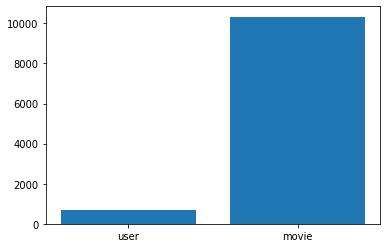

In [8]:
plt.bar(['user','movie'],[len(rating.userId.unique()),len(movie.movieId.unique())])

### Data Preparation

#### Normalisasi

melakukan normalisasi data ke 1 dikarenakan perkalian dot menghasilkan nilai dari 0 sampai 1

In [9]:
rating['rating'] = (rating['rating'] - rating['rating'].min())/(rating['rating'].max()-rating['rating'].min())

melihat nilai min dan max apakah sudah berhasil dinormalisasi atau belum

In [10]:
rating.describe()

,userId,movieId,rating,timestamp
count,105339.000000,105339.000000,105339.000000,1.053390e+05
mean,364.924539,13381.312477,0.670411,1.130424e+09
std,197.486905,26170.456869,0.232194,1.802660e+08
min,1.000000,1.000000,0.000000,8.285650e+08
25%,192.000000,1073.000000,0.555556,9.711008e+08
50%,383.000000,2497.000000,0.666667,1.115154e+09
75%,557.000000,5991.000000,0.777778,1.275496e+09
max,668.000000,149532.000000,1.000000,1.452405e+09


#### One Hot Encoding

In [11]:
movie = pd.concat([movie,movie.genres.str.get_dummies('|')],axis=1)

In [12]:
movie = movie[movie['(no genres listed)']==0]

#### Penggabungan Data

In [13]:
data = rating.merge(movie,on=['movieId'],how='left')

In [14]:
dataSiap = data[['userId','movieId','rating']]

In [15]:
dataSiap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105339 entries, 0 to 105338
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   105339 non-null  int64  
 1   movieId  105339 non-null  int64  
 2   rating   105339 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 3.2 MB


In [16]:
num_user = dataSiap['userId'].unique().max()

In [17]:
num_movie = dataSiap['movieId'].unique().max()

data userId dan movie Id dimulai dari 1 maka perlu dikurangi 1 sehingga data bermulai dari index 0 

In [ ]:
dataSiap['userId'] = dataSiap['userId']-1 

In [ ]:
dataSiap['movieId'] = dataSiap['movieId']-1 

#### Split data

In [20]:
X_train,X_test,Y_train,Y_test = train_test_split(dataSiap[['userId','movieId']],dataSiap['rating'],test_size=0.1,random_state=42)

### Modelling

In [21]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_resto, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) 
    self.resto_embedding = layers.Embedding( 
        num_resto,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.resto_bias = layers.Embedding(num_resto, 1) 
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) 
    user_bias = self.user_bias(inputs[:, 0])
    resto_vector = self.resto_embedding(inputs[:, 1]) 
    resto_bias = self.resto_bias(inputs[:, 1])
 
    dot_user_resto = tf.tensordot(user_vector, resto_vector, 2) 
 
    x = dot_user_resto + user_bias + resto_bias
    
    return tf.nn.sigmoid(x)

In [22]:
model = RecommenderNet(num_user, num_movie, 50)
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [23]:
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = 80,
    epochs = 50,
    validation_data = (X_test, Y_test)
)

Epoch 1/50
1186/1186 [==============================] - 18s 12ms/step - loss: 0.6334 - root_mean_squared_error: 0.2323 - val_loss: 0.6137 - val_root_mean_squared_error: 0.2121
Epoch 2/50
1186/1186 [==============================] - 14s 12ms/step - loss: 0.6110 - root_mean_squared_error: 0.2089 - val_loss: 0.6108 - val_root_mean_squared_error: 0.2087
Epoch 3/50
1186/1186 [==============================] - 14s 12ms/step - loss: 0.6067 - root_mean_squared_error: 0.2043 - val_loss: 0.6058 - val_root_mean_squared_error: 0.2037
Epoch 4/50
1186/1186 [==============================] - 14s 12ms/step - loss: 0.6053 - root_mean_squared_error: 0.2027 - val_loss: 0.6053 - val_root_mean_squared_error: 0.2032
Epoch 5/50
1186/1186 [==============================] - 14s 12ms/step - loss: 0.6067 - root_mean_squared_error: 0.2037 - val_loss: 0.6033 - val_root_mean_squared_error: 0.2008
Epoch 6/50
1186/1186 [==============================] - 19s 16ms/step - loss: 0.6062 - root_mean_squared_error: 0.2030 -

### Evaluation

#### Loss

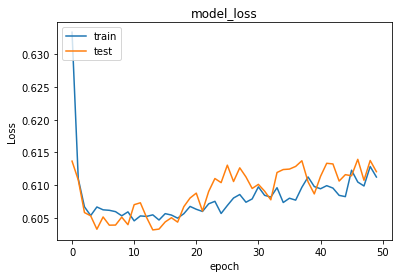

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### plot Metric

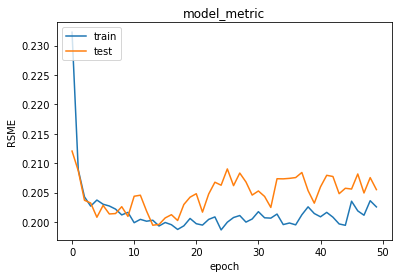

In [25]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metric')
plt.ylabel('RSME')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Result

memilih user secara random

In [26]:
selectedUser = np.random.randint(0,num_user)

In [27]:
selectedUserDf = X_train.copy()

In [28]:
selectedUserDf = selectedUserDf[selectedUserDf['userId']==selectedUser]

melihat film yang telah ditonton oleh pengguna yang terpilih

In [29]:
selectedUserDf

,userId,movieId
82337,570,2
82349,570,735
82341,570,31
82345,570,94
82343,570,51
82339,570,16
82342,570,35
82351,570,779
82360,570,1356
82348,570,707


In [30]:
movieIdforSelectedUser = selectedUserDf['movieId'].unique()

In [31]:
movieIdforSelectedUser

array([   2,  735,   31,   94,   51,   16,   35,  779, 1356,  707,  259,
        785,  838,    5, 1072,   24, 1209,  798,  857, 1355,    0, 1182])

In [32]:
idMovieAll = dataSiap.movieId.unique()

In [33]:
idMovieAll.shape

(10325,)

membuang film yang telah ditonton pengguna sehingga yang akan dipredict hanya yang belum

In [34]:
tesMovie = list(set(idMovieAll) - set(movieIdforSelectedUser))

In [35]:
testMatrix = [[selectedUser,i] for i in tesMovie]

In [36]:
testMatrix = np.array(testMatrix)

In [37]:
testPredict = model.predict(testMatrix)

In [38]:
testPredict

array([[0.5444175 ],
       [0.3795092 ],
       [0.50239533],
       ...,
       [0.6300652 ],
       [0.6973791 ],
       [0.77956575]], dtype=float32)

In [39]:
testMatrix

array([[  570,     1],
       [  570,     3],
       [  570,     4],
       ...,
       [  570, 98289],
       [  570, 98295],
       [  570, 98303]])

mengurutkan nilai prediksi dari yang terbesar, dikarenakan nilai terbesar adalah nilai yang memungkinkan untuk film yang akan disukai pengguna

In [40]:
testPredict = np.argsort(np.squeeze(testPredict))[::-1]

In [41]:
movieRecom = testMatrix[testPredict[:10]]

In [42]:
movieLike = dataSiap[dataSiap['userId']==533].sort_values(by='rating',ascending=False).head(10)['movieId']

In [43]:
print("TOP 10 dengan rating tertinggi")
for i in movieLike:
  print('{}'.format(movie[movie['movieId']==i+1]['title'].values[0]))

TOP 10 dengan rating tertinggi
Boot, Das (Boat, The) (1981)
Reservoir Dogs (1992)
Star Wars: Episode VI - Return of the Jedi (1983)
Pulp Fiction (1994)
Femme Nikita, La (Nikita) (1990)
Groundhog Day (1993)
Shawshank Redemption, The (1994)
Donnie Brasco (1997)
Forrest Gump (1994)
Sleepers (1996)


In [44]:
print("TOP 10 of reccomendation movie")
for i in movieRecom:
  print('{}'.format(movie[movie['movieId']==i[1]+1]['title'].values[0]))

TOP 10 of reccomendation movie
42 Up (1998)
Mansfield Park (1999)
Black Mirror (2011)
Ruby Sparks (2012)
Bicycle Thieves (a.k.a. The Bicycle Thief) (a.k.a. The Bicycle Thieves) (Ladri di biciclette) (1948)
Wild Tales (2014)
Fireworks (Hana-bi) (1997)
South Park: Imaginationland (2008)
Interstate 60 (2002)
Grapes of Wrath, The (1940)
